# T05: Multiclass Logistic Regression

- TA: WANG Zhiwei, HKUST

- Date: 2022-10-11

## Let's first recall logistic regression for classification!

- Training set $\mathcal{D}=\left\{\mathbf{x}_i, y_i\right\}_{i=1}^N$, where $y_i \in\{0,1\}$.
- Probabilistic model
$$
p(y \mid \mathbf{x}, \beta)=\operatorname{Ber}\left(y \mid \sigma\left(\beta^{\top} \mathbf{x}\right)\right)
$$
    - $\sigma(z)$ is the sigmoid/logistic/logit function.
        $$
        \sigma(z)=\frac{1}{1+\exp (-z)}=\frac{e^z}{e^z+1}
        $$
    - It maps $\mathbb{R}$ to $(0,1)$.

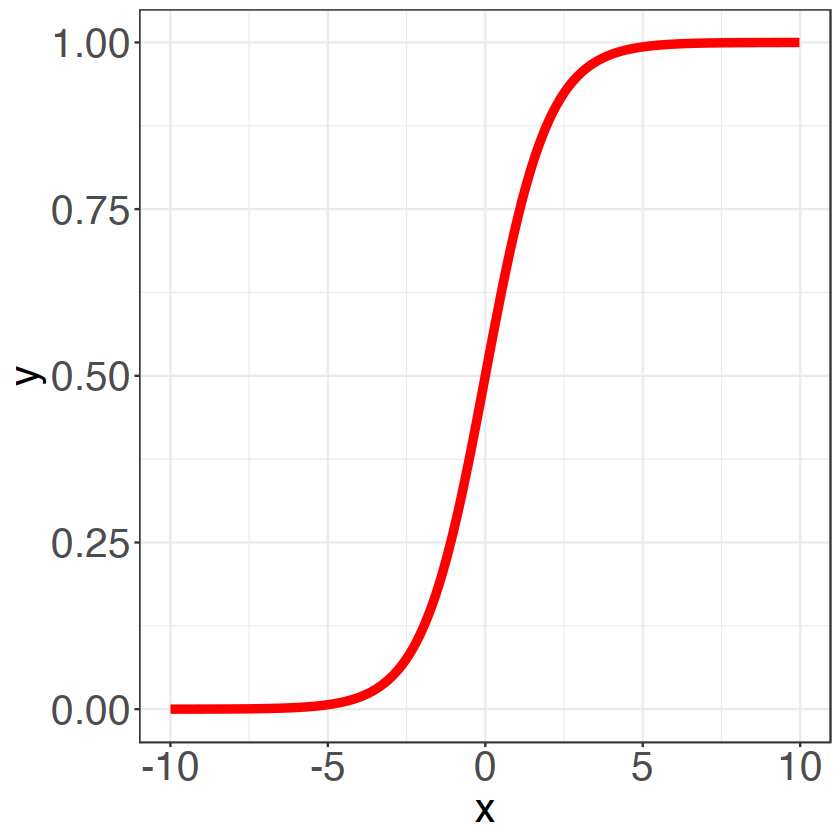

In [1]:
set.seed(20221011)
library(ggplot2)

x <- runif(1000, -10, 10)
y <- 1 / (1 + exp(-x))
ggplot(NULL, aes(x = x, y = y)) +
    geom_line(color = "red", size = 2) +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    )

## The maximum likelihood estimation

- Recall that, the likelihood is the joint probability function of joint density function of the data.

- Here, we have independent observations $\left(\mathbf{x}_i, y_i\right), i=1, \ldots, n$, each follow the (conditional) distribution
$$
P\left(y_i=1 \mid \mathbf{x}_i\right)=\frac{1}{1+\exp \left(-\beta^T \mathbf{x}_i\right)}=1-P\left(y_i=0 \mid \mathbf{x}_i\right)
$$

- So, the joint probability function is
$$
\prod_{i=1, \ldots, n ; y_i=1} p\left(y_i=1 \mid \mathbf{x}_i\right) \prod_{i=1, \ldots, n ; y_i=0} p\left(y_i=0 \mid \mathbf{x}_i\right)
$$
which can be conveniently written as
$$
\prod_{i=1}^n \frac{\exp \left(y_i \beta^T \mathbf{x}_i\right)}{1+\exp \left(\beta^T \mathbf{x}_i\right)}
$$

- The likelihood function is the same as the joint probability function, but viewed as a function of $\beta$. The log-likelihood function is
$$
\ell=\sum_{i=1}^n\left[y_i \beta^T x_i-\log \left(1+\exp \left(\beta^T \mathbf{x}_i\right)\right)\right]
$$

- Unlike linear regression, we can no longer write down the MLE in closed form. Instead, we need to use optimization algorithms to compute it.
    - Gradient descent
    - Newton’s method

## Multiclass logistic regression

We now extend the two-class logistic regression approach to the setting of $K > 2$ classes.
This extension is known as multiclass logistic regression or multinomial logistic regression.

To do this, we first select a single class to serve as the **baseline** (why?); without loss of generality, we select the $K$-th class for this role.
Then
$$
\operatorname{Pr}(Y=k \mid X=x)=\frac{e^{\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p}}{1+\sum_{l=1}^{K-1} e^{\beta_{l 0}+\beta_{l 1} x_1+\cdots+\beta_{l p} x_p}}
$$
for $k=1, \ldots, K-1$, and
$$
\operatorname{Pr}(Y=K \mid X=x)=\frac{1}{1+\sum_{l=1}^{K-1} e^{\beta_{l 0}+\beta_{l 1} x_1+\cdots+\beta_{l p} x_p}} .
$$
It is not hard to show that for $k=1, \ldots, K-1$,
$$
\log \left(\frac{\operatorname{Pr}(Y=k \mid X=x)}{\operatorname{Pr}(Y=K \mid X=x)}\right)=\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p
$$
**Notice that the log odds between any pair of classes is linear in the features.**

## A toy example

### Generate data

In [2]:
N <- 1000 # Sample size
P <- 2 # Number of features
K <- 3 # Number of classes

X <- matrix(rnorm(N * P), N, P) # Features, N * P
b <- matrix(rnorm(P * (K - 1), mean = 3), P, K - 1) # Coefficients, P * (K - 1)

head(X)
head(b)

-0.150291390,-1.4336430
0.800363460,0.4086914
-0.672994703,-2.3707612
-2.057448013,1.9045292
0.299558658,-1.2850531
-0.006283879,-0.7488323


3.650434,0.0851641
3.639788,4.0788753


In [3]:
f <- exp(X %*% b) # N * (K - 1)
prob <- f / (1 + rowSums(f)) # Prob of Class 1 and 2, N * (K - 1)
prob <- cbind(prob, 1 - rowSums(prob)) # Prob of Class 1, 2, and 3, N * K

head(f)
head(prob)

3.129803e-03,2.849959e-03
8.220568e+01,5.669856e+00
1.532859e-05,5.962984e-05
5.607405e-01,1.984488e+03
2.776993e-02,5.428677e-03
6.402193e-02,4.712607e-02


3.111199e-03,2.833018e-03,0.9940557831
9.249529e-01,6.379546e-02,0.0112516898
1.532744e-05,5.962537e-05,0.9999250472
2.823397e-04,9.992141e-01,0.0005035123
2.687763e-02,5.254243e-03,0.9678681236
5.761782e-02,4.241206e-02,0.8999701239


In [4]:
y <- t(apply(prob, 
             MARGIN = 1, 
             FUN = function(x) {rmultinom(n = 1, size = 1, prob = x)}))
head(y) # Each column represents a class

0,0,1
1,0,0
0,0,1
0,1,0
0,0,1
0,0,1


[1] 3 1 3 2 3 3
Levels: 1 2 3

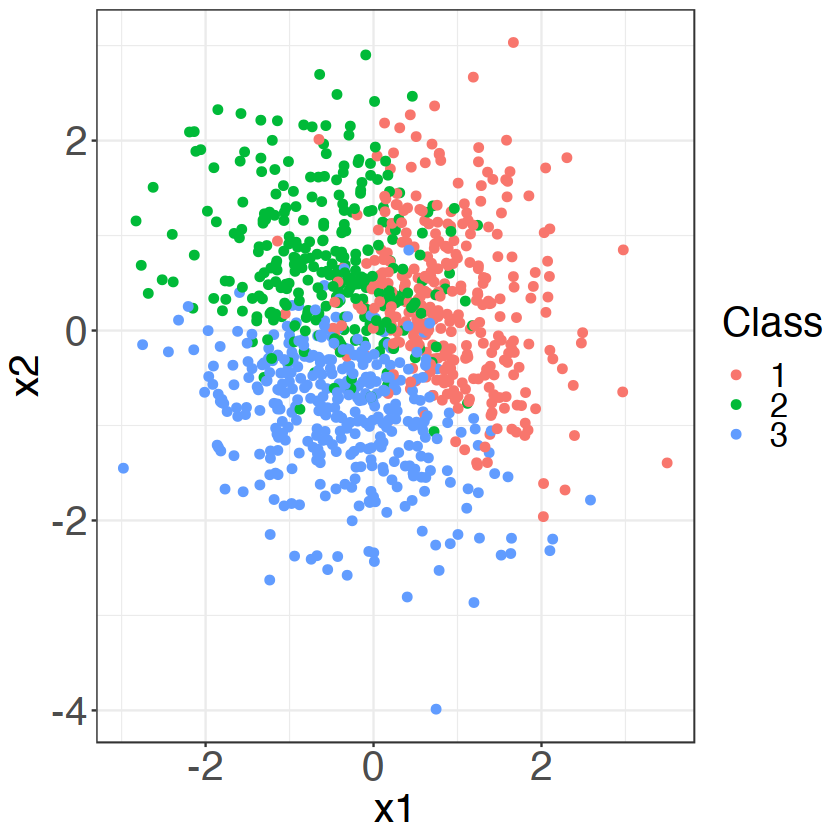

In [5]:
# Visulization

## Encode to 1, 2, and 3
classEncode <- function(x){
    if(x[1] == 1){
        return(1)
    }else if (x[2] == 1){
        return(2)
    }else{
        return(3)
    }
}

y_encode <- as.vector(apply(y, MARGIN = 1, FUN = classEncode))
y_encode <- factor(y_encode, levels = c(1, 2, 3))
y_encode[1:6]

## ggplot2
ggplot(data = NULL, aes(x = X[, 1], y = X[, 2], color = y_encode)) +
    geom_point(size = 2) +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))

### Now let's fit multiclass logistic regression!

In [6]:
multLogReg <- function(X, y, b_init = NULL, lambda = 0, tol = 1e-4, inner_iter = 100, outer_iter = 100) {
    # Data dimension
    P <- dim(X)[2]
    N <- dim(y)[1]
    K <- dim(y)[2]

    # Start solving

    X <- cbind(rep(1, N), X) # Add the intercept

    XtX <- t(X) %*% X
    Lambda <- diag(c(0, rep(lambda, P)))

    if (is.null(b_init)) {
        b <- matrix(0, P + 1, K - 1) # Allow different initialization of beta0
    } else {
        b <- b_init
    }

    b_old <- b
    f <- exp(X %*% b_old)
    prob <- f / (1 + rowSums(f))
    # prob <- 1 / (1 + exp(-X %*% b_old))

    for (out in 1:outer_iter) { # Out iteration
        for (l in 1:(K - 1)) {
            for (inner in 1:inner_iter) { # Inner iteration
                # diag_W <- prob * (1 - prob)
                b_tmp <- b[, l] # Coefficients of l-th class
                # z <- 0.25 * X %*% as.matrix(b_tmp) + (y[, l + 1] - prob[, l]) # Use 1-st class as baseline
                z <- 0.25 * X %*% as.matrix(b_tmp) + (y[, l] - prob[, l]) # Use last class as baseline
                b[, l] <- solve(0.25 * XtX + Lambda) %*% (t(X) %*% z)

                if (max(abs(b_tmp - b[, l])) / norm(as.matrix(b[, l]), "F") < tol) {
                    break
                }

                f[, l] <- exp(X %*% b[, l])
                prob <- f / (1 + rowSums(f))

                # Safe guard
                prob[prob > 0.999] <- 0.999
                prob[prob < 0.001] <- 0.001
            }
        }

        if (max(abs(b_old - b)) / norm(b, "F") < tol) {
            break
        }

        b_old <- b
    }

    return(b = b)
}

In [7]:
b_hat <- multLogReg(X, y)
b_hat

0.2219709,0.5417368
4.1257671,0.6599843
4.6319477,4.9405993


Remember that for $k=1, \ldots, K-1$,
$$
\log \left(\frac{\operatorname{Pr}(Y=k \mid X=x)}{\operatorname{Pr}(Y=K \mid X=x)}\right)=\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p.
$$
Let $\frac{\operatorname{Pr}(Y=k \mid X=x)}{\operatorname{Pr}(Y=K \mid X=x)} = 1$, we can get
$$
\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p = 0.
$$
In this case $p = 2$, so
$$
\beta_{k 0}+\beta_{k 1} x_1+\beta_{k 2} x_2 = 0,\\
x_2 = - \frac{\beta_{k 0}}{\beta_{k 2}} - \frac{\beta_{k 1}}{\beta_{k 2}} x_1.
$$

Suppose we do not know which is the **baseline** class and assume it was chosen at random. (Actually we know it.)

Let's first visualize the known classification line.

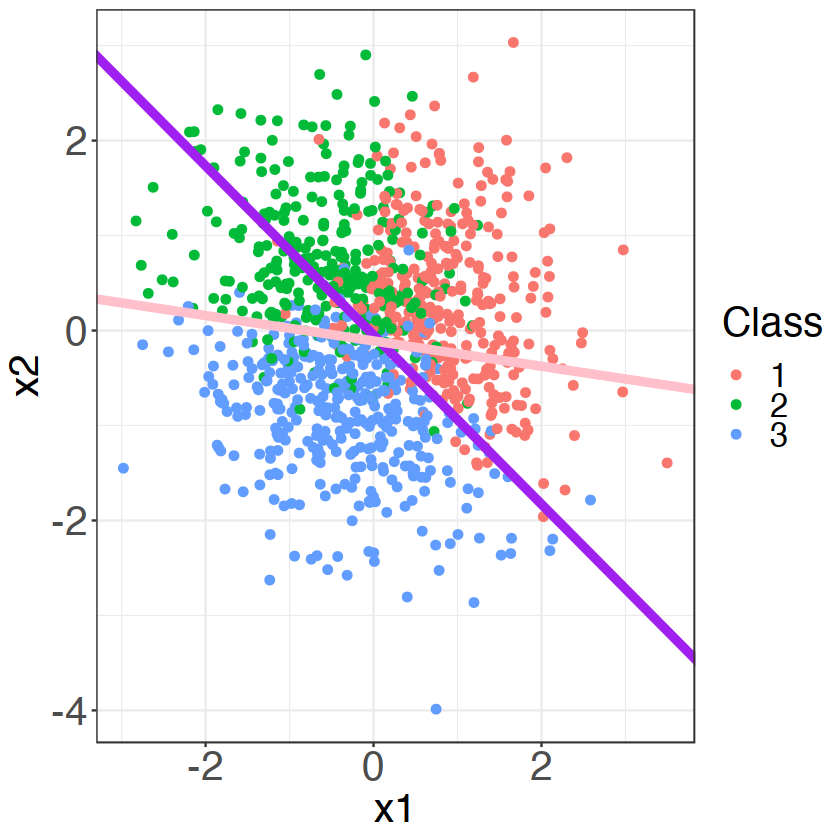

In [8]:
ggplot(data = NULL, aes(x = X[, 1], y = X[, 2], color = y_encode)) +
    geom_point(size = 2) +
    geom_abline(intercept = - b_hat[1, 1] / b_hat[3, 1], slope = - b_hat[2, 1] / b_hat[3, 1], size = 2, color = "purple") +
    geom_abline(intercept = - b_hat[1, 2] / b_hat[3, 2], slope = - b_hat[2, 2] / b_hat[3, 2], size = 2, color = "pink") +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))

In [9]:
b_hat

0.2219709,0.5417368
4.1257671,0.6599843
4.6319477,4.9405993


We can see that the purple line is between class 1 and 3, and the pink line is between class 2 and 3.
So the **baseline** here is class 3, and
$$
\log \left(\frac{\operatorname{Pr}(Y=1 \mid X=x)}{\operatorname{Pr}(Y=3 \mid X=x)}\right) = 0.22 + 4.13 x_1 + 4.63 x_2, \\
\log \left(\frac{\operatorname{Pr}(Y=2 \mid X=x)}{\operatorname{Pr}(Y=3 \mid X=x)}\right) = 0.54 + 0.66 x_1 + 4.94 x_2.
$$
Therefore,
$$
\log \left(\frac{\operatorname{Pr}(Y=2 \mid X=x)}{\operatorname{Pr}(Y=3 \mid X=x)}\right) = (0.22-0.54) + (4.13 - 0.66) x_1 + (4.63 - 4.94) x_2.
$$

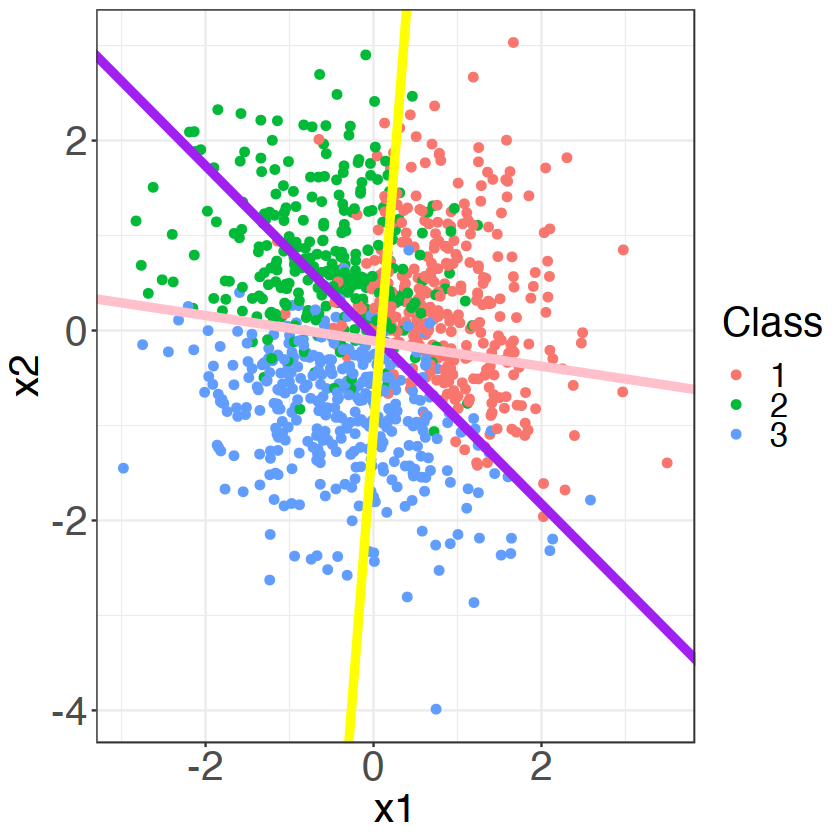

In [10]:
# The full figure
ggplot(data = NULL, aes(x = X[, 1], y = X[, 2], color = y_encode)) +
    geom_point(size = 2) +
    geom_abline(intercept = - b_hat[1, 1] / b_hat[3, 1], slope = - b_hat[2, 1] / b_hat[3, 1], size = 2, color = "purple") +
    geom_abline(intercept = - b_hat[1, 2] / b_hat[3, 2], slope = - b_hat[2, 2] / b_hat[3, 2], size = 2, color = "pink") +
    geom_abline(intercept = - (b_hat[1, 1] - b_hat[1, 2]) / (b_hat[3, 1] - b_hat[3, 2]), slope = - (b_hat[2, 1] - b_hat[2, 2]) / (b_hat[3, 1] - b_hat[3, 2]), size = 2, color = "yellow") +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))